# Data Exploration
**Purpose**: Explore the financial_data.db database and understand available data

**Date**: 2026-02-22

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set up paths
project_root = Path.cwd().parent
db_path = project_root / 'data' / 'financial_data.db'

print(f"Project root: {project_root}")
print(f"Database: {db_path}")
print(f"Database exists: {db_path.exists()}")

Project root: /home/archy/Desktop/Server/FinancialData/model_regime_comparison
Database: /home/archy/Desktop/Server/FinancialData/model_regime_comparison/data/financial_data.db
Database exists: True


## 1. Database Schema Overview

In [4]:
# Connect to database
conn = sqlite3.connect(db_path)

# Get all tables
tables_query = "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;"
tables = pd.read_sql_query(tables_query, conn)

print(f"Found {len(tables)} tables:")
print(tables)

Found 19 tables:
                       name
0                  dim_bond
1             dim_commodity
2               dim_company
3          dim_crypto_asset
4           dim_data_source
5                  dim_date
6    dim_economic_indicator
7              dim_exchange
8           dim_filing_type
9                dim_issuer
10          fact_bond_price
11     fact_commodity_price
12     fact_company_metrics
13        fact_crypto_price
14  fact_economic_indicator
15     fact_filing_analysis
16          fact_sec_filing
17         fact_stock_price
18          sqlite_sequence


## 2. Stock Price Data

In [5]:
# Get stock price table schema
schema_query = "PRAGMA table_info(fact_stock_price);"
schema = pd.read_sql_query(schema_query, conn)
print("Stock Price Table Schema:")
print(schema[['name', 'type', 'notnull']])

Stock Price Table Schema:
                    name            type  notnull
0               price_id         INTEGER        1
1             company_id         INTEGER        1
2                date_id         INTEGER        1
3            exchange_id         INTEGER        0
4              source_id         INTEGER        1
5             open_price  NUMERIC(18, 4)        0
6             high_price  NUMERIC(18, 4)        0
7              low_price  NUMERIC(18, 4)        0
8            close_price  NUMERIC(18, 4)        1
9         adjusted_close  NUMERIC(18, 4)        0
10                volume          BIGINT        0
11          price_change  NUMERIC(18, 4)        0
12  price_change_percent   NUMERIC(8, 4)        0
13            created_at        DATETIME        0
14            updated_at        DATETIME        0


In [6]:
# Count total stock prices
count_query = "SELECT COUNT(*) as count FROM fact_stock_price;"
count = pd.read_sql_query(count_query, conn)
print(f"Total stock price records: {count['count'].iloc[0]:,}")

Total stock price records: 93,710


In [7]:
# Get date range
date_range_query = """
SELECT 
    MIN(d.date) as min_date,
    MAX(d.date) as max_date,
    COUNT(DISTINCT d.date) as n_dates
FROM fact_stock_price s
JOIN dim_date d ON s.date_id = d.date_id;
"""
date_range = pd.read_sql_query(date_range_query, conn)
print("\nDate Range:")
print(date_range)


Date Range:
     min_date    max_date  n_dates
0  1972-08-25  2026-01-02    13666


In [8]:
# Get available tickers
tickers_query = """
SELECT DISTINCT c.ticker, c.company_name
FROM fact_stock_price s
JOIN dim_company c ON s.company_id = c.company_id
ORDER BY c.ticker;
"""
tickers = pd.read_sql_query(tickers_query, conn)
print(f"\nTotal tickers available: {len(tickers)}")
print("\nFirst 20 tickers:")
print(tickers.head(20))


Total tickers available: 58

First 20 tickers:
     ticker                                 company_name
0      AAPL                                   Apple Inc.
1    ADS.DE                                    adidas AG
2    AIR.PA                                    Airbus SE
3      AMZN                             Amazon.com, Inc.
4   ASML.AS                            ASML Holding N.V.
5       BAC                  Bank of America Corporation
6    BAS.DE                                      BASF SE
7   BAYN.DE                     Bayer Aktiengesellschaft
8    BMW.DE  Bayerische Motoren Werke Aktiengesellschaft
9    BNP.PA                               BNP Paribas SA
10     BP.L                                    BP p.l.c.
11    CS.PA                                       AXA SA
12      CVX                          Chevron Corporation
13   DBK.DE             Deutsche Bank Aktiengesellschaft
14       DD                      DuPont de Nemours, Inc.
15      DOW                             

## 3. Check Sentinel Sector Tickers

In [11]:
# Define sector tickers
sector_tickers = {
    'tech': ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'META', 'TSLA', 'AMD', 'INTC', 'CRM', 'ADBE'],
    'finance': ['JPM', 'BAC', 'GS', 'MS', 'WFC', 'C', 'BLK', 'AXP', 'USB', 'PNC'],
    'crypto': ['BTC-USD', 'ETH-USD', 'SOL-USD', 'BNB-USD', 'ADA-USD'],
    'commodities': ['GLD', 'SLV', 'USO', 'DBC'],
    'cyclicals': ['CAT', 'DE', 'BA', 'HON', 'MMM', 'GE', 'UPS', 'FDX', 'DAL', 'UAL']
}

# Check which tickers are available
available_tickers = set(tickers['ticker'].tolist())

for sector, ticker_list in sector_tickers.items():
    available = [t for t in ticker_list if t in available_tickers]
    missing = [t for t in ticker_list if t not in available_tickers]
    
    print(f"\n{sector.upper()}:")
    print(f"  Available: {len(available)}/{len(ticker_list)}")
    if available:
        print(f"  Tickers: {', '.join(available)}")
    if missing:
        print(f"  Missing: {', '.join(missing)}")


TECH:
  Available: 6/10
  Tickers: AAPL, MSFT, NVDA, GOOGL, META, TSLA
  Missing: AMD, INTC, CRM, ADBE

FINANCE:
  Available: 4/10
  Tickers: JPM, BAC, GS, WFC
  Missing: MS, C, BLK, AXP, USB, PNC

CRYPTO:
  Available: 0/5
  Missing: BTC-USD, ETH-USD, SOL-USD, BNB-USD, ADA-USD

COMMODITIES:
  Available: 0/4
  Missing: GLD, SLV, USO, DBC

CYCLICALS:
  Available: 0/10
  Missing: CAT, DE, BA, HON, MMM, GE, UPS, FDX, DAL, UAL


## 4. Sample Data for Training Period (2019-2024)

In [12]:
# Load sample data for tech sector
sample_query = """
SELECT 
    d.date,
    c.ticker,
    s.open_price as open,
    s.high_price as high,
    s.low_price as low,
    s.close_price as close,
    s.adjusted_close,
    s.volume,
    s.price_change_percent
FROM fact_stock_price s
JOIN dim_date d ON s.date_id = d.date_id
JOIN dim_company c ON s.company_id = c.company_id
WHERE 
    c.ticker IN ('AAPL', 'MSFT', 'GOOGL')
    AND d.date BETWEEN '2019-01-01' AND '2024-12-31'
ORDER BY d.date, c.ticker;
"""

sample_df = pd.read_sql_query(sample_query, conn)
sample_df['date'] = pd.to_datetime(sample_df['date'])

print(f"Sample data loaded: {len(sample_df)} rows")
print(f"Date range: {sample_df['date'].min()} to {sample_df['date'].max()}")
print(f"\nSample:")
print(sample_df.head(10))

Sample data loaded: 4530 rows
Date range: 2019-01-02 00:00:00 to 2024-12-31 00:00:00

Sample:
        date ticker       open       high        low      close  \
0 2019-01-02   AAPL  36.818556  37.759881  36.661668  37.538811   
1 2019-01-02  GOOGL  50.974850  52.641756  50.879569  52.338547   
2 2019-01-02   MSFT  93.143652  95.202072  92.572907  94.612617   
3 2019-01-03   AAPL  34.225159  34.638772  33.754498  33.799664   
4 2019-01-03  GOOGL  52.139549  52.913203  50.735160  50.888996   
5 2019-01-03   MSFT  93.658224  93.742436  90.944847  91.131981   
6 2019-01-04   AAPL  34.355901  35.311487  34.182375  35.242550   
7 2019-01-04  GOOGL  51.737085  53.595048  51.454222  53.499271   
8 2019-01-04   MSFT  93.302712  95.913168  92.563550  95.370491   
9 2019-01-07   AAPL  35.347156  35.378059  34.681573  35.164120   

  adjusted_close     volume  price_change_percent  
0           None  148158800                1.9562  
1           None   31868000                2.6752  
2           

In [13]:
# Check data completeness per ticker
completeness = sample_df.groupby('ticker').agg({
    'date': ['count', 'min', 'max'],
    'close': lambda x: x.isna().sum()
})
completeness.columns = ['n_records', 'first_date', 'last_date', 'missing_close']
print("\nData Completeness:")
print(completeness)


Data Completeness:
        n_records first_date  last_date  missing_close
ticker                                                
AAPL         1510 2019-01-02 2024-12-31              0
GOOGL        1510 2019-01-02 2024-12-31              0
MSFT         1510 2019-01-02 2024-12-31              0


## 5. Visualize Sample Data

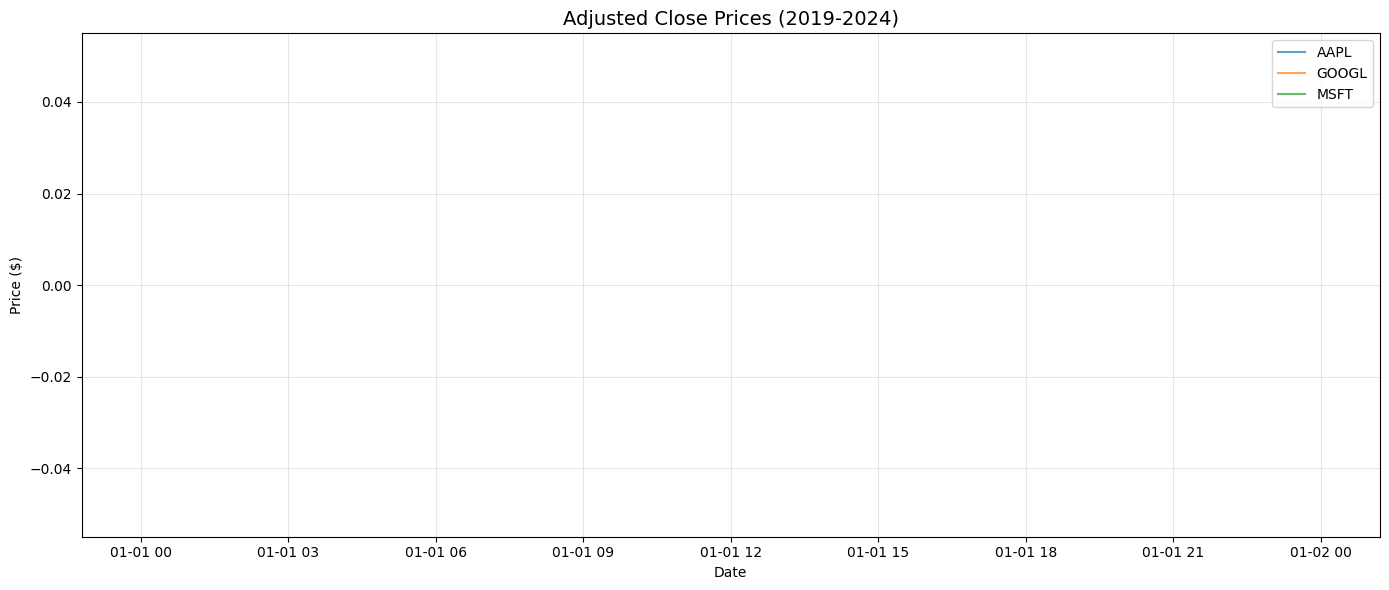

In [14]:
# Plot adjusted close prices
plt.figure(figsize=(14, 6))

for ticker in sample_df['ticker'].unique():
    ticker_df = sample_df[sample_df['ticker'] == ticker]
    plt.plot(ticker_df['date'], ticker_df['adjusted_close'], label=ticker, alpha=0.7)

plt.title('Adjusted Close Prices (2019-2024)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

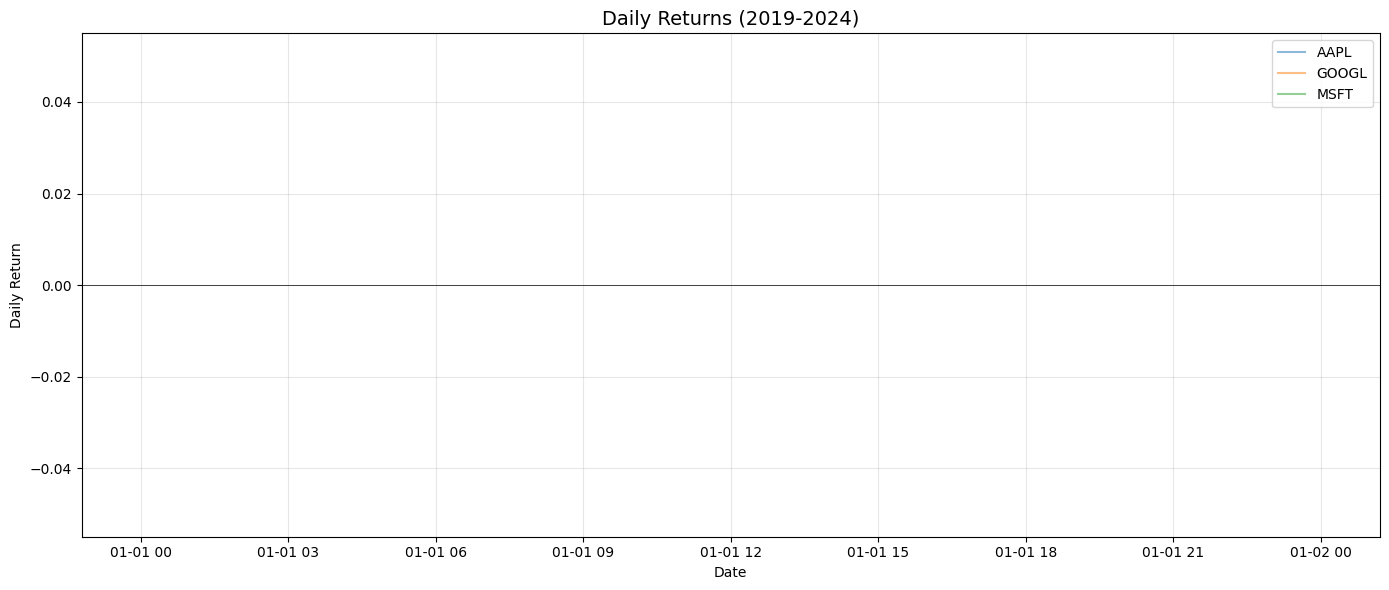

In [15]:
# Calculate and plot daily returns
sample_df['returns'] = sample_df.groupby('ticker')['adjusted_close'].pct_change()

plt.figure(figsize=(14, 6))

for ticker in sample_df['ticker'].unique():
    ticker_df = sample_df[sample_df['ticker'] == ticker]
    plt.plot(ticker_df['date'], ticker_df['returns'], label=ticker, alpha=0.5)

plt.title('Daily Returns (2019-2024)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

## 6. Summary Statistics

In [16]:
# Calculate summary statistics per ticker
stats = sample_df.groupby('ticker')['returns'].agg([
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('sharpe', lambda x: (x.mean() / x.std()) * np.sqrt(252))  # Annualized Sharpe
])

print("\nSummary Statistics (Daily Returns):")
print(stats)
print("\nNote: Returns are daily, Sharpe ratio is annualized")


Summary Statistics (Daily Returns):
       mean  std  min  max  sharpe
ticker                            
AAPL    NaN  NaN  NaN  NaN     NaN
GOOGL   NaN  NaN  NaN  NaN     NaN
MSFT    NaN  NaN  NaN  NaN     NaN

Note: Returns are daily, Sharpe ratio is annualized


## 7. Close Connection

In [17]:
conn.close()
print("Database connection closed")

Database connection closed


## Next Steps

1. ✅ Database is accessible and contains data
2. ⏳ Create data loader module (`src/data/data_loader.py`)
3. ⏳ Test data loader with sectors
4. ⏳ Begin model training

See `02_data_loader_implementation.ipynb` to build the data loader.